In [1]:
# %% Imports
import jax
from jax import random, numpy as jnp
from functools import partial
from jax import lax
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from code import fwd_solver, bayes_ridge_update, evidence
from sklearn.linear_model import BayesianRidge
from jax.scipy.stats import gamma
%load_ext autoreload
%autoreload 2

In [2]:
data = jnp.load('test_data.npy', allow_pickle=True).item()
y, X = data['y'], data['X']

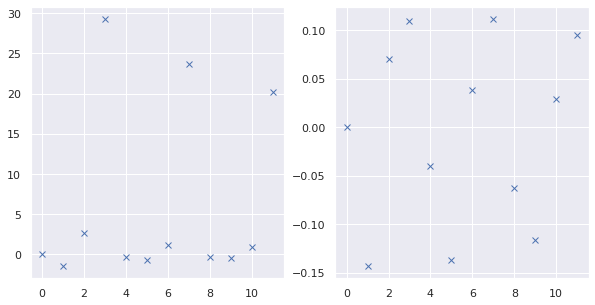

In [4]:
# Quick check with least squares
coeffs_lstsq = jnp.linalg.lstsq(y, X)[0]
coeffs_normed = jnp.linalg.lstsq(y, X / jnp.linalg.norm(X, keepdims=True, axis=0))[0]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(coeffs_lstsq.squeeze(), 'x')
plt.subplot(122)
plt.plot(coeffs_normed.squeeze(), 'x')

Let's make a new version with a tol and prior keyword:

In [5]:
n_samples = X.shape[0]
hyper_prior =  jnp.stack([n_samples / 2, 1 / (n_samples / 2 * 1e-4)],  axis=0)
prior_init = jnp.stack([1., 1. / jnp.var(y)], axis=0)

In [6]:
update = jax.jit(lambda prior: bayes_ridge_update(prior_params=prior, y=y, X=X, hyper_prior_params=hyper_prior))

In [7]:
z_star = fwd_solver(update, prior_init, tol=1e-4)

In [8]:
z_star

DeviceArray([ 0.36742833, 49.686714  ], dtype=float32)

Same result. To compare to sklearn, we first run it with a prenormalized theta:

In [8]:
X_normed = X / jnp.linalg.norm(X, keepdims=True, axis=0)
update = jax.jit(lambda prior: bayes_ridge_update(y=y, X=X_normed, prior_params=prior, hyper_prior_params=hyper_prior))                                              

In [9]:
z_star = fwd_solver(update, prior_init, tol=1e-3)

In [10]:
z_star

DeviceArray([ 0.3674301, 49.68671  ], dtype=float32)

In [11]:
reg = BayesianRidge(tol=1e-3, 
                    normalize=False, 
                    fit_intercept=False, 
                    alpha_1=hyper_prior[0], 
                    alpha_2=hyper_prior[1], 
                    compute_score=True)

In [12]:
reg.fit(X_normed, y.squeeze())

BayesianRidge(alpha_1=DeviceArray(500., dtype=float32),
              alpha_2=DeviceArray(20., dtype=float32), compute_score=True,
              fit_intercept=False)

In [13]:
print(reg.lambda_, reg.alpha_)

0.3674246 49.73669


In [14]:
print(reg.scores_)

[1861.4547 1968.3906 1968.3945 1968.3945 1968.3945]


So its correct :-).

let's also verify the evidence function we've written:

In [15]:
evidence(z_star, y, X_normed, hyper_prior_params=hyper_prior)

(DeviceArray(1968.3939, dtype=float32),
 DeviceArray([[ 5.6724742e-02],
              [-9.6143293e-01],
              [ 3.5012689e+00],
              [ 3.5096151e-01],
              [-7.0219129e-02],
              [-2.9230318e+00],
              [ 4.3358850e-01],
              [-1.3628960e-02],
              [-2.3009777e-03],
              [-1.8180455e+00],
              [-2.6216370e-01],
              [-5.4168719e-01]], dtype=float32))

thats within numerical accuracy, great!